In [1]:
%matplotlib inline

%load_ext Cython

import os
import sys
import struct
from time import time
import subprocess as sp

sys.path.append("/home/matthew/lscsoft/.virtualenvs/master/lib/python2.7/site-packages")

import numpy as np
from matplotlib import pyplot as pl
import matplotlib as mpl

import lalpulsar

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] ='Avant Garde, Helvetica, Computer Modern Sans serif'
mpl.rcParams['font.size'] = 15

# Binary system time delays

For a pulsar in a binary system the signal will need to be transformed from the pulsar frame to the binary system barycentre frame. The time delay that achieves this transformation is given in Equation 5 of [Taylor & Weisberg](http://ukads.nottingham.ac.uk/abs/1989ApJ...345..434T) as

$$
\Delta t = \left\{x \sin{\omega_0} \left(\cos{E} - e\right) + \left[x \cos{\omega_0}\left(1-e^2\right)^{1/2} + \gamma\right]\sin{E}\right\} \times \left\{1-\frac{2\pi x}{P_b}\frac{\left[ \cos{\omega_0}\cos{E}\left(1-e^2 \right)^{1/2} - \sin{\omega_0}\sin{E} \right]}{\left(1-e\cos{E}\right)} \right\},
$$

where $x \equiv a\sin{i}/c$ is the projected semi-major axis, $\omega_0$ is the longitude of periastron, $P_b$ is the orbital period, $e$ is the eccentricity, $\gamma$ measures the gravitational redshift and time dilation (effectively conveying the Einstein delay), and $E$ is the eccentric anomaly defined by

$$
E - e\sin{E} = \frac{2\pi}{P_b}\left(t_b - T_0\right),
$$

where $T_0$ is the time of periastron passage, and $t_b$ is the barycentric arrival time. The eccentric anomaly can be solved for numerically, and (under the assumption that the period, longitude of periastron, and eccentricity are not evolving with time, or are only very slowly evolving) this the only time dependent term. This term is therefore open to approximation using a reduced order model (an alternative could be to produce a look-up table for this function).

The reduced order model can use a training set generated at a series of times over one orbit, such that $0 < t_b \le P_b$, and the two variables are $e$ and $T_0/P_b$. For the training set we can choose a fixed period and then draw points in $e$ uniformly between zero and some maximum value, and draw points in $T_0/P_b$ uniformly between 0 and 1. For different period sources the reduced order model basis points time steps can just be scaled by $(P_b)_{\rm new}/P_b$.

We produce a ROM for the two quantities, $\sin{E}$ and $\cos{E}$, that are required for the binary time delay as these is the most computationally intensive part of the model.

In [81]:
%%cython --compile-args=-O2

import numpy as np
cimport numpy as np

from libc.math cimport sqrt, cos, sin

from lalpulsar import ComputeEccentricAnomaly

# function to return binary BT model
def binary_model(w0, T0, Pb, asini, ecc, gamma, ts):
    # calculate the binary time delay for a Keplerian orbit (including gamma parameter
    # that accounts for relativistic Einstein delay effects)
    
    orbits = (ts - T0)/Pb
    
    phase = 2.*np.pi*np.fmod(orbits, 1.)

    l = len(phase)

    u = np.zeros(l)
    #su = np.zeros(l)
    #cu = np.zeros(l)
    for i in xrange(l):
        u[i] = ComputeEccentricAnomaly(phase[i], ecc)
        #su[i] = sin(u)
        #cu[i] = cos(u)

    su = np.sin(u)
    cu = np.cos(u)
    
    sw = sin(w0)
    cw = cos(w0)
    
    x = asini
    e = ecc
    
    one_e2 = sqrt(1. - e**2)
    
    deltaTW1 = x*sw*(cu - e) + (x*cw*one_e2 + gamma)*su
    deltaTW2 = (2.*np.pi*x/Pb)*(cw*one_e2*cu - sw*su)/(1.0 - e*cu)
    
    dt = -(deltaTW1*(1. - deltaTW2))
    
    return dt, su, cu

def eccentric_anomaly( T0, Pb, ecc, ts ):
    # calculate sine and cosine of the eccentric anomaly
    
    orbits = (ts - T0)/Pb
    phase = 2.*np.pi*np.fmod(orbits, 1.)
    l = len(phase)
    #su = np.zeros(l)
    #cu = np.zeros(l)
    u = np.zeros(l)
    
    for i in xrange(l):
        u[i] = ComputeEccentricAnomaly(phase[i], ecc)
        #su[i] = sin(u)
        #cu[i] = cos(u)

    su = np.sin(u)
    cu = np.cos(u)

    return su, cu

def binary_model_EA(w0, Pb, asini, ecc, gamma, sinU, cosU):
    # compute the binary time delay when passed the sine and cosine of the eccentric anomaly U

    sw = sin(w0)
    cw = cos(w0)

    x = asini
    e = ecc

    one_e2 = sqrt(1. - e**2)

    tw1 = x*sw*(cosU - e) + (x*cw*one_e2 + gamma)*sinU
    tw2 = (2.*np.pi*x/Pb)*(cw*one_e2*cosU - sw*sinU)/(1.0 - e*cosU)

    return -tw1*(1. - tw2)

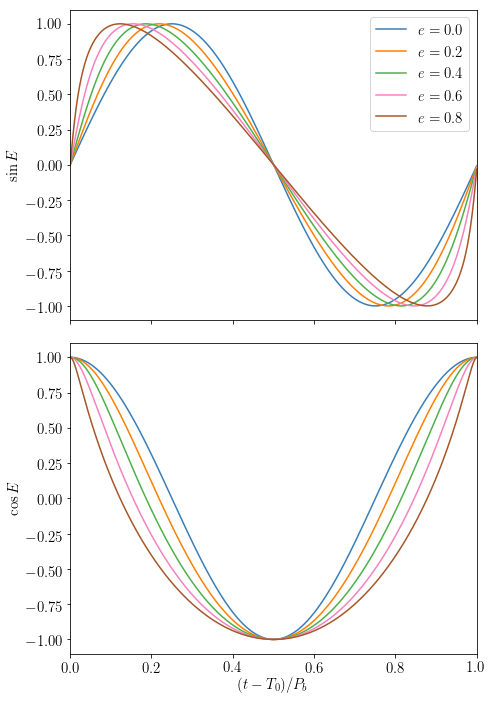

In [3]:
fig, axe = pl.subplots(2, 1, figsize=(7,10), sharex=True)

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

for i, ecc in enumerate([0., 0.2, 0.4, 0.6, 0.8]):
    su, cu = eccentric_anomaly(0., 1., ecc, np.linspace(0., 1.-1e-3, 1000))
    axe[0].plot(np.linspace(0., 1., 1000), su, color=colors[i], label=r'$e = {0:.1f}$'.format(ecc))
    axe[1].plot(np.linspace(0., 1., 1000), cu, color=colors[i])

axe[0].set_xlim([0., 1.])
axe[0].set_ylabel(r'$\sin{E}$')
axe[0].legend();

axe[1].set_xlim([0., 1.])
axe[1].set_ylabel(r'$\cos{E}$')
axe[1].set_xlabel(r'$(t-T_0)/P_b$')

fig.tight_layout()
fig.savefig('ecc_anomaly.pdf')

In [4]:
# generate training points
eccmax = 0.25    # maximum eccentricity to be used
ntraining = 5000 # number of training points to use

sp.call('generate_trainingpoints_binary.py -N {} -e {}'.format(ntraining, eccmax), shell=True);

In [44]:
configtemplate = r"""// Configuration file for running greedycpp with the 'BinaryBarycenter' model

// start time, end time and number of time points
x_min = {starttime};     // GPS start time
x_max = {endtime};       // GPS end time
quad_points = {npoints}; // number of time points

// model information
model_name = "BinaryBarycenter_{eccu}";

// inner product information
quad_type = 1;
weighted_inner = false;

param_dim = 2;
load_from_file = true; // load training points (T0 and eccentricity values) from file
p1_scale = 1.0;        // scaling for T0
p2_scale = 1.0;        // scaling for eccentricity

ts_file = "TS_points.txt";  // location of training points file

// greedy algoritm information
seed = 0;
tol = {tolerance};  // greedy algorithm tolerance (maximum residual time error)
max_RB = {maxrb};   // estimated upper bound in number of reduced bases

// output information
export_tspace = false;
output_dir = ".";      // output directory
output_data_format = "both"; // output both in binary and text format
"""

# create start time and end time to span one hour with one point every second
starttime = 900000000.0
endtime = 900003600.0
npoints = 3601

tolerance = 1e-8 # tolerance in seconds
maxrb = 500 # maximum number of reduced bases

configdic = {}
configdic['starttime'] = starttime
configdic['endtime'] = endtime
configdic['npoints'] = npoints
configdic['tolerance'] = tolerance
configdic['maxrb'] = maxrb

In [45]:
rbs = []
Nbs = []
invVs = []
ts_nodes = []

binpath = os.path.abspath('../../../bin') # greedycpp binary path 

# set library path
lds = 'export LD_LIBRARY_PATH=${LD_LIBRARY_PATH}:/home/matthew/lscsoft/.virtualenvs/master/lib'

for gu in ['SinU', 'CosU']:
    configfile = '{}.cfg'.format(gu)

    configdic['eccu'] = gu

    fp = open(configfile, 'w')
    fp.write(configtemplate.format(**configdic))
    fp.close()
    
    gcppexec = os.path.join(binpath, 'greedyBarycenter')
    
    # run greedy algorithm on binary training points
    sp.call('{}; {} {}'.format(lds, gcppexec, configfile), shell=True);

    # get time stamps
    ts = np.loadtxt('quad_rule.txt')
    t = ts[:,0]

    lenb = len(t)

    # get number of basis
    Nb = np.loadtxt('ApproxErrors.txt').shape[0]
    Nbs.append(Nb)
    
    # read in binary version of reduced basis data
    bf = open('Basis.bin', 'rb')
    fc = bf.read()
    bf.close()

    rb = np.zeros((Nbs[-1],lenb))
    for i in range(Nbs[-1]):
        tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
        rb[i] = tmpvals[::2] # just get real part
    
    rbs.append(rb)
    
    # get interpolation matrix
    eimexec = os.path.join(binpath, 'eim')
    sp.call('{}; {} {} {} gsl'.format(lds, eimexec, configfile, './'), shell=True);
    
    # read in binary version of empirical interpolation matrix
    invV = np.zeros((Nbs[-1], Nbs[-1]))
    bf = open('invV.bin', 'rb')
    fc = bf.read()
    bf.close()
    for i in range(Nbs[-1]):
        tmpvals = struct.unpack('d'*Nbs[-1]*2, fc[(i*8*Nbs[-1]*2):(i+1)*8*Nbs[-1]*2])
        invV[i] = tmpvals[::2] # just get real part
    invVs.append(invV)
    
    # load interpolation nodes
    ts_nodes.append(np.loadtxt('EIM_nodes.txt'))

Number of reduced bases for sin(E) = 34
Number of reduced bases for cos(E) = 36


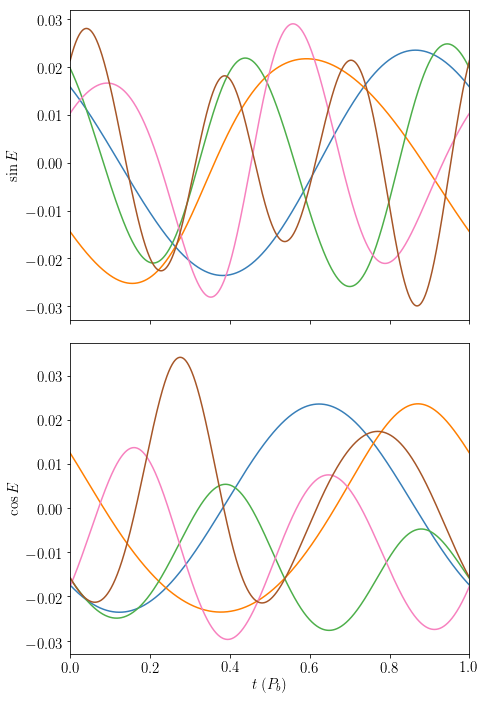

In [46]:
print('Number of reduced bases for sin(E) = {}'.format(Nbs[0]))
print('Number of reduced bases for cos(E) = {}'.format(Nbs[1]))

# plot the first five reduced bases

fig, axr = pl.subplots(2, 1, figsize=(7,10), sharex=True)

colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# fixed parameters
Pb = (endtime-starttime)

for i in range(5):
    axr[0].plot((t-t[0])/Pb, rbs[0][i], color=colors[i])
    axr[1].plot((t-t[0])/Pb, rbs[1][i], color=colors[i])

axr[0].set_xlim([0., 1.])
axr[0].set_ylabel(r'$\sin{E}$')

axr[1].set_xlim([0., 1.])
axr[1].set_ylabel(r'$\cos{E}$')
axr[1].set_xlabel(r'$t~(P_b)$')

fig.tight_layout()
fig.savefig('ecc_anomaly_basis.pdf')

In [100]:
# get random phases, start times and eccentricities and check residuals
nbins = 10000

ecc = eccmax*np.random.rand(nbins)
w0 = 2.*np.pi*np.random.rand(nbins)
T0 = np.random.rand(nbins)
asini = 100.*np.random.rand(nbins)
gamma = 1e-3*np.random.rand(nbins)

deltaTs = np.zeros(lenb)
deltaTsArray = []

# get deltaTs calculated over all times using LALBarycenter routines
for i in range(nbins):
    dt, _, _ = binary_model(w0[i], t[0]+T0[i]*Pb, Pb, asini[i], ecc[i], gamma[i], t)    
    deltaTsArray.append(np.copy(dt))

In [87]:
# perform some timing evalution
ts = np.zeros(len(t))
tsTW1 = np.zeros(len(t))
tsTW2 = np.zeros(len(t))

ta = time()
dt, _, _ = binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], t)
tb = time()

%timeit binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], t)
%timeit binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], [t[0]])
%timeit binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], t[0:30])
%timeit binary_model(w0[-1], t[0]+T0[-1]*Pb, Pb, asini[-1], ecc[-1], gamma[-1], t[0:60])

print("Total time for evalution = %.9f" % (tb-ta))
print("time for one evaluation = %.9f" % ((tb-ta)/len(t)))

1000 loops, best of 3: 1.63 ms per loop
100000 loops, best of 3: 17.3 µs per loop
10000 loops, best of 3: 27.6 µs per loop
10000 loops, best of 3: 40.4 µs per loop
Total time for evalution = 0.001929998
time for one evaluation = 0.000000536


In [101]:
SU = []
CU = []
B = []

for j in range(len(Nbs)):
    # get deltaTs calculated using interpolant
    dtvals = np.zeros(Nbs[j])

    B.append(np.einsum('ik,ij->kj', invVs[j], rbs[j]))

    # get deltats calculated using the reduced basis
    for i in range(nbins):
        # get values of eccentric anomaly at given points
        su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes[j])
        
        # create new version of deltaTs using empirical interpolant matrix
        if j == 0:
            SU.append(np.dot(su, B[j]))
            sut = su
        else:
            CU.append(np.dot(cu, B[j]))
            cut = cu

# time linear algebra
%timeit np.einsum('ik,ij->kj', invVs[0], rbs[0])
%timeit np.einsum('ik,ij->kj', invVs[1], rbs[1])

%timeit np.dot(sut, B[0])
%timeit np.dot(cut, B[1])

sudiff = []
cudiff = []
deltaTsArrayFull = []
for i in range(nbins):
    deltaTsArrayFull.append(binary_model_EA(w0[i], Pb, asini[i], ecc[i], gamma[i], SU[i], CU[i]))
    su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], t)
    sudiff.append(np.abs(SU[i] - su))
    cudiff.append(np.abs(CU[i] - cu))

%timeit eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes[j])
%timeit binary_model_EA(w0[i], Pb, asini[i], ecc[i], gamma[i], SU[i], CU[i])

1000 loops, best of 3: 1.84 ms per loop
100 loops, best of 3: 2.12 ms per loop
The slowest run took 7.73 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 33 µs per loop
The slowest run took 151.45 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 26 µs per loop
10000 loops, best of 3: 20.6 µs per loop
The slowest run took 4.82 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 39 µs per loop


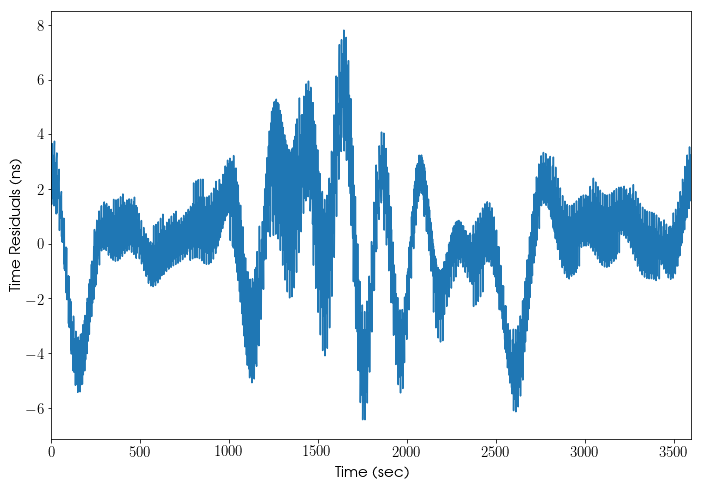

In [102]:
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t-t[0], (deltaTsArrayFull[0]-deltaTsArray[0])*1e9)

ax1.set_ylabel('Time Residuals (ns)')
ax1.set_xlabel('Time (sec)')
ax1.set_xlim([0., (t[-1]-t[0])])

fig.tight_layout()

In [103]:
# get residual errors (in ns) for binary time delay and sin(E)/cos(E)
maxdt = []
maxsu = []
maxcu = []
for i in range(nbins):
    maxdt.append(np.max(np.fabs((deltaTsArrayFull[i]-deltaTsArray[i])*1e9)))
    maxsu.append(np.max(sudiff[i])*1e9)
    maxcu.append(np.max(cudiff[i])*1e9)

In [104]:
# compare times
full = 0.0016*1e6 # time in microseconds

rom = 2. * 20.0   # time for sinE/cosE delay at nodes
rom += 2. * 27.0  # matrix multiplication
rom += 38.0       # combining terms for full time delay

print full, rom, (full/rom)

1600.0 132.0 12.1212121212


On the above examples see how well linear interpolation half-way between each of time stamps from delays calculated using the ROM compares to the full calculation at those new time positions.

In [105]:
from scipy.interpolate import splrep, splev

newts = t[0:-1] + np.diff(t)/2.

maxdtsint = []
maxdtsintspl = []

for i in range(nbins):
    dtinterplinear = np.interp(newts, t, deltaTsArrayFull[i])
    tspl, cspl, kspl = splrep(t, deltaTsArrayFull[i])
    dtinterpspline = splev(newts, (tspl, cspl,  kspl))
    
    dtactual, _, _ = binary_model(w0[i], t[0]+T0[i]*Pb, Pb, asini[i], ecc[i], gamma[i], newts)
    
    maxdtsint.append(np.max(np.fabs((dtinterplinear-dtactual)*1e9)))
    maxdtsintspl.append(np.max(np.fabs((dtinterpspline-dtactual)*1e9)))

%timeit splev(newts, (tspl, cspl,  kspl))

10000 loops, best of 3: 194 µs per loop


Now run the code on a variety of simulated binaries, but allow the period to vary.

In [115]:
Pbmin = 600. # 10 minute minimum
Pbmax = Pb*10.

Pbs = Pbmin + (Pbmax-Pbmin)*np.random.rand(nbins)
#Pbs = np.linspace(Pbmin, Pbmax, nbins)
asini = 100.*np.random.rand(nbins)

ecc = eccmax*np.random.rand(nbins)
w0 = 2.*np.pi*np.random.rand(nbins)
T0 = np.random.rand(nbins)
gamma = 1e-3*np.random.rand(nbins)

deltaTsArrayTrue = []

# get deltaTs calculated using interpolant
SUNew = []
CUNew = []

for j in range(len(Nbs)):
    # get deltats calculated using the reduced basis
    for i in range(nbins):
        su, cu = eccentric_anomaly(t[0]+T0[i]*Pb, Pb, ecc[i], ts_nodes[j])
        
        # create new version of deltaTs using empirical interpolant matrix
        if j == 0:
            SUNew.append(np.dot(su, B[j]))
        else:
            CUNew.append(np.dot(cu, B[j]))

        # get actual delays
        dtvals, _, _ = binary_model(w0[i], t[0]+T0[i]*Pbs[i], Pbs[i], asini[i], ecc[i], gamma[i], t)
        deltaTsArrayTrue.append(dtvals)

deltaTsArrayFullNew = []
differences = []
differenceslinear = []

for i in range(nbins):
    deltaTsArrayFullNew.append(binary_model_EA(w0[i], Pbs[i], asini[i], ecc[i], gamma[i], SUNew[i], CUNew[i]))
    tspl, cspl, kspl = splrep((t-t[0])*Pbs[i]/Pb, deltaTsArrayFullNew[i])
    dtinterpspline2 = splev(np.mod(t-t[0], Pbs[i]), (tspl, cspl,  kspl))
    differences.append(np.max(np.fabs((dtinterpspline2-deltaTsArrayTrue[i])*1e9)))
    dtinterplin = np.interp(np.mod(t-t[0], Pbs[i]), (t-t[0])*Pbs[i]/Pb, deltaTsArrayFullNew[i])
    differenceslinear.append(np.max(np.fabs((dtinterplin-deltaTsArrayTrue[i])*1e9)))

In [114]:
%timeit splrep((t-t[0])*Pbs[i]/Pb, deltaTsArrayFullNew[i])
%timeit splev(np.mod(t-t[0], Pbs[i]), (tspl, cspl,  kspl))
%timeit np.interp(np.mod(t-t[0], Pbs[i]), (t-t[0])*Pbs[i]/Pb, deltaTsArrayFullNew[i])

The slowest run took 482.38 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 499 µs per loop
The slowest run took 344.42 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 268 µs per loop
10000 loops, best of 3: 104 µs per loop


577.085787157 579.352399832 544.11108863
1.5
1.47
0.84


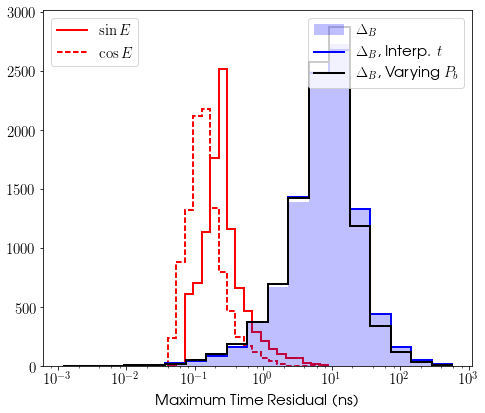

In [113]:
fig, ax3 = pl.subplots(figsize=(7,6))

minrange = np.min([np.min(maxdt), np.min(maxdtsintspl), np.min(differences)])
maxrange = np.max([np.max(maxdt), np.max(maxdtsintspl), np.max(differences)])
bins = np.logspace(np.log10(minrange), np.log10(maxrange), 20)

binsU = np.logspace(np.log10(np.min([np.min(maxsu), np.min(maxcu)])), np.log10(np.max([np.max(maxsu), np.max(maxcu)])), 20)

ax3.hist(maxsu, bins=binsU, histtype='step', color='r', lw=2)
h1 = pl.Line2D((0,0), (0,0), color='r', lw=2) # proxy for legend (to give line rather than box)
ax3.hist(maxcu, bins=binsU, histtype='step', color='r', ls='--', lw=2)
h2 = pl.Line2D((0,0), (0,0), color='r', lw=2, ls='--') # proxy for legend (to give line rather than box)

_, _, h3 = ax3.hist(maxdt, bins=bins, histtype='stepfilled', color='b', alpha=0.25)
#ax3.hist(maxdt, bins=bins, histtype='step', color='b', edgecolor='b', lw=2) # repeat for edge
ax3.hist(maxdtsintspl, bins=bins, histtype='step', color='b', lw=2)
h4 = pl.Line2D((0,0), (0,0), color='b', lw=2)
ax3.hist(differences, bins=bins, histtype='step', color='k', lw=2)
h5 = pl.Line2D((0,0), (0,0), color='k', lw=2)
ax3.set_xscale('log')
ax3.set_xlabel('Maximum Time Residual (ns)');

l1 = pl.legend([h1, h2], [r'$\sin{E}$', r'$\cos{E}$'], loc='upper left')
ax3.add_artist(l1)
ax3.legend([h3[0], h4, h5], [r'$\Delta_B$', r'$\Delta_B$, Interp. $t$', r'$\Delta_B$, Varying $P_b$'])

fig.tight_layout()
fig.savefig('bt_accuracy.pdf')

print np.max(maxdt), np.max(maxdtsintspl), np.max(differences)
print 100.*float(len([m for m in maxdt if m > 100.]))/len(maxdt)
print 100.*float(len([m for m in maxdtsintspl if m > 100.]))/len(maxdtsintspl)
print 100.*float(len([m for m in differences if m > 100.]))/len(differences)

17010.7531012 120222.77015


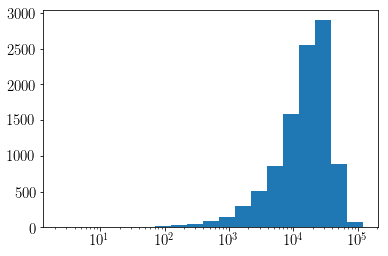

In [119]:
binsl = np.logspace(np.log10(np.min(differenceslinear)), np.log10(np.max(differenceslinear)), 20)
pl.hist(differenceslinear, bins=binsl)
ax = pl.gca()
ax.set_xscale('log')
print np.median(differenceslinear), np.max(differenceslinear)